# Autoencoders

In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Data

In [6]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [15]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name, ignore_verifications=True)

C:\ProgramData\Anaconda3\lib\site-packages\datasets\load.py:1748: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [17]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [76]:
bs = 64
tds = dsd.with_transform(transformi)

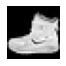

In [77]:
ds = tds["train"]
img = ds[0]["image"]

show_image(img, figsize=(1,1));

In [78]:
cf = collate_dict(ds)

In [79]:
def collate_(b): return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

In [80]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [81]:
dt = dls["train"]
dv =dls["test"]

xb,yb = next(iter(dt))
xb.shape,yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [82]:
labels = ds.features[y].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [83]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

titles, len(titles)

(('Ankle boot',
  'T - shirt / top',
  'T - shirt / top',
  'Dress',
  'T - shirt / top',
  'Pullover',
  'Sneaker',
  'Pullover',
  'Sandal',
  'Sandal',
  'T - shirt / top',
  'Ankle boot',
  'Sandal',
  'Sandal',
  'Sneaker',
  'Ankle boot'),
 16)

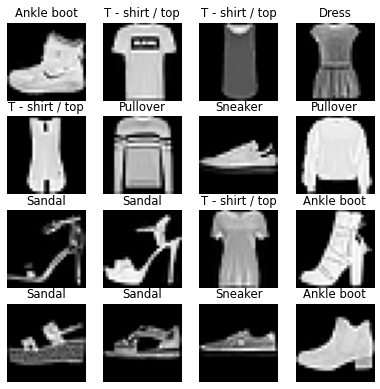

In [84]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

## Warmup - classify

In [85]:
from torch import optim

bs = 64
lr = 0.4

In [86]:
cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

In [87]:
# opt = optim.SGD(cnn.parameters(), lr=lr)
# loss,acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

84% accuracy. world leaderboard is 94%. needs improving. very slow on cpu

In [88]:
dsd["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x61B9DFDA00>,
 'label': 9}

# Autoencoder

In [92]:
input_t = torch.arange(1, 5, dtype=torch.float32).view(1, 1, 2, 2)
input_t

tensor([[[[1., 2.],
          [3., 4.]]]])

In [93]:
m = nn.UpsamplingNearest2d(scale_factor=2)
m(input_t)

tensor([[[[1., 1., 2., 2.],
          [1., 1., 2., 2.],
          [3., 3., 4., 4.],
          [3., 3., 4., 4.]]]])

In [94]:
m = nn.UpsamplingNearest2d(scale_factor=3)
m(input_t)

tensor([[[[1., 1., 1., 2., 2., 2.],
          [1., 1., 1., 2., 2., 2.],
          [1., 1., 1., 2., 2., 2.],
          [3., 3., 3., 4., 4., 4.],
          [3., 3., 3., 4., 4., 4.],
          [3., 3., 3., 4., 4., 4.]]]])

In [95]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [96]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')
     

In [97]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

In [107]:
ae = nn.Sequential(
    nn.ZeroPad2d(2),
    conv(1,2),
    conv(2,4),
    deconv(4,2),
    deconv(2,1, act=False),
    nn.ZeroPad2d(-2),
    nn.Sigmoid()
).to(def_device)

In [108]:
eval(ae, F.mse_loss, dv)

0 0.185


In [112]:
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.130
1 0.125
2 0.124
3 0.124
4 0.124


In [113]:
opt = optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.124
1 0.124
2 0.124
3 0.124
4 0.124


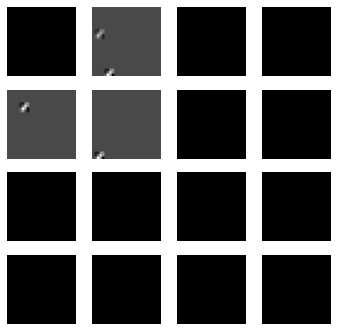

In [115]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

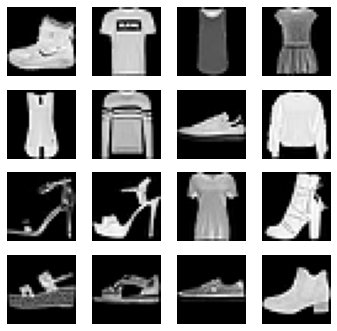

In [117]:
show_images(xb[:16].data.cpu(), imsize=1.5)

use gpu. not great on cpu